In [58]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import dateutil
from torch import nn
import torch.nn.functional as F
import math


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor, shape [seq_len, batch_size, d_model]
        """
        x = x + self.pe[:x.size(0), :]
        return x



class SharedAttentionLayer(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        # We use PyTorch's built-in MultiheadAttention
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
    
    def forward(self, x, attn_mask=None):
        """
        x shape: (seq_len, batch_size, d_model)
        Returns: (seq_len, batch_size, d_model)
        """
        # Queries, Keys, Values are all x in self-attention
        attn_output, _ = self.multihead_attn(x, x, x, attn_mask=attn_mask)
        return attn_output

class PrivateEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        """
        Forward pass with optional attention mask.
        Args:
        - x: Tensor of shape (seq_len, batch_size, d_model)
        - attn_mask: Tensor of shape (seq_len, seq_len) for causal masking (optional)
        
        Returns:
        - x: (seq_len, batch_size, d_model)
        """
        # --- Self-Attention with Mask ---
        attn_output, _ = self.self_attn(x, x, x, attn_mask=attn_mask)  
        x = x + self.dropout1(attn_output)  # Residual connection
        x = self.norm1(x)
        
        # --- Feed-Forward Sub-Layer ---
        ff_out = self.linear2(self.dropout(F.relu(self.linear1(x))))
        x = x + self.dropout2(ff_out)  # Residual connection
        x = self.norm2(x)
        return x
    
class GeneralGlobalSharingMTL(nn.Module):
    def __init__(self, input_dim ,d_model, nhead, d_ff, num_private_layers, num_tasks, dropout=0.1, device='cpu'):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding added here
        self.positional_encoding = PositionalEncoding(d_model, max_len=128).to(device)

        # One shared attention for all tasks
        self.shared_attn = SharedAttentionLayer(d_model, nhead, dropout)
        
        # Private encoders: a separate stack for each task
        self.private_encoders = nn.ModuleList([
            nn.ModuleList([
                PrivateEncoderLayer(d_model, nhead, d_ff, dropout)
                for _ in range(num_private_layers)
            ]) for _ in range(num_tasks)
        ])
        
        # A separate fusion layer for each task (or you can share one if you prefer)
        self.fusion_layers = nn.ModuleList([
            nn.Linear(2 * d_model, d_model) for _ in range(num_tasks)
        ])
        
        self.num_private_layers = num_private_layers
        self.num_tasks = num_tasks
        self.device = device

    def _generate_square_subsequent_mask(self, seq_len):
        mask = torch.triu(
            torch.full((seq_len, seq_len), float('-inf'), dtype=torch.float32, device=self.device),
            diagonal=1
        )
        return mask
    
    def forward(self, x, task_id):
        """
        x shape: (seq_len, batch_size, d_model)
        task_id: which task we are processing (0 to num_tasks-1)
        
        Returns: (seq_len, batch_size, d_model)
        """
        seq_len = x.size(0)
        # Project to input dimension
        x = self.input_projection(x)
        
        # Add Positional Encoding
        x = self.positional_encoding(x)
        
        # Generate mask for attention
        attn_mask = self._generate_square_subsequent_mask(seq_len)
        
        # Shared representation (once per batch)
        s = self.shared_attn(x, attn_mask=attn_mask)
        
        # Initialize private representation for this task
        z = x
        
        # Retrieve this task's stack of private encoders + fusion
        task_encoders = self.private_encoders[task_id]
        fusion_layer = self.fusion_layers[task_id]
        
        # Pass through each private encoder for this task
        for encoder_layer in task_encoders:
            # z = encoder_layer(z, attn_mask=attn_mask)
            # combined = torch.cat([z, s], dim=-1)
            # z = fusion_layer(combined)
            s = self.shared_attn(z, attn_mask=attn_mask)  # 🔄 Recompute S after each layer
            z = encoder_layer(z, attn_mask=attn_mask)
            combined = torch.cat([z, s], dim=-1)
            z = fusion_layer(combined)
        
        return z

# Single-Task Model (without shared attention branch)
class SingleTaskModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, d_ff, num_layers, dropout=0.1, device='cpu'):
        """
        Single-Task Model with an input embedding layer and multiple private encoder layers.
        Args:
        - input_dim: Number of input features.
        - d_model: Embedding dimension after projection.
        - nhead: Number of attention heads.
        - d_ff: Dimension of the feed-forward network.
        - num_layers: Number of encoder layers.
        - dropout: Dropout rate.
        """
        super().__init__()
        self.device = device
        # Input embedding layer to project raw input to d_model dimension
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding added here
        self.positional_encoding = PositionalEncoding(d_model, max_len=128).to(device)

        # Stacked encoder layers
        self.encoders = nn.ModuleList([
            PrivateEncoderLayer(d_model, nhead, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
    def _generate_square_subsequent_mask(self, seq_len):
        mask = torch.triu(
            torch.full((seq_len, seq_len), float('-inf'), dtype=torch.float32, device=self.device),
            diagonal=1
        )
        return mask
    
    def forward(self, x, *args, **kwargs):
        """
        Forward pass for the single-task model.
        Args:
        - x: Input tensor of shape (seq_len, batch_size, input_dim)
        Returns:
        - z: Output tensor of shape (seq_len, batch_size, d_model)
        """
        seq_len = x.size(0)
        z = self.input_projection(x)  # 🔄 Embed input
        z = self.positional_encoding(z)                # 🛰️ Add positional encoding
        attn_mask = self._generate_square_subsequent_mask(seq_len)
        
        for encoder in self.encoders:
            z = encoder(z, attn_mask=attn_mask)
        return z


# ---------- ForecastHead (Multi-step Forecasting) ----------
class ForecastHead(nn.Module):
    def __init__(self, d_model, out_dim=1, forecast_steps=1):
        """
        Forecast head supporting direct multi-step forecasting.
        Args:
        - d_model: Embedding dimension of the model.
        - out_dim: Output dimension per forecast step.
        - forecast_steps: Number of future steps to forecast.
        """
        super().__init__()
        self.forecast_steps = forecast_steps
        self.proj = nn.Linear(d_model, out_dim * forecast_steps)

    def forward(self, z):
        """
        Forward pass for forecasting.
        Args:
        - z: Tensor (seq_len, batch_size, d_model)
        Returns:
        - y_pred: Tensor (batch_size, forecast_steps, out_dim)
        """
        z_last = z[-1]  # Extract last time step (batch_size, d_model)
        y_pred = self.proj(z_last)  # (batch_size, out_dim * forecast_steps)
        y_pred = y_pred.view(y_pred.shape[0], self.forecast_steps, -1)  # Reshape for multi-step output
        return y_pred

# DATA LOADING

In [72]:
from sklearn.preprocessing import MinMaxScaler

def df_to_X_y(df, features, target, window_size=32, horizon=1):
    """
    Converts a DataFrame into supervised learning format for multi-step time series forecasting.

    Args:
    - df (pd.DataFrame): DataFrame containing time series data.
    - features (list): List of columns to use as features.
    - target (str): The target column to predict.
    - window_size (int): Past window size.
    - horizon (int): Number of future steps.

    Returns:
    - X (np.array): Features (num_samples, window_size, num_features).
    - y (np.array): Targets (num_samples, horizon).
    """
    # Ensure target is in features
    if target not in features:
        features = [target] + features

    data = df[features].to_numpy()  # Features including target's history
    target_data = df[target].to_numpy()  # Target series

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        # Past window_size feature values (including target)
        X.append(data[i:i + window_size])

        # Multi-step target: a sequence of future steps
        y.append(target_data[i + window_size : i + window_size + horizon])

    return np.array(X), np.array(y)  # y shape: (num_samples, horizon)



# ---------- Data Loader Function (Target included in features) ----------
def load_and_preprocess_site_data(site_path, features, target, window_size=32, horizon=1, min_date=None, max_date=None, batch_size=16, device='cpu'):
    """
    Loads and preprocesses time series data for a given site with specified features and target,
    ensuring the target column's historical values are included in the features.
    
    Args:
    - site_path (str): Path to the CSV file.
    - features (list): List of feature columns to use.
    - target (str): Target column name.
    - window_size (int): Past window size.
    - horizon (int): Forecast horizon.
    - min_date, max_date (str or datetime): Optional date filtering.
    - batch_size (int): Batch size for DataLoader.
    - device (str): 'cpu' or 'cuda'.

    Returns:
    - train_loader, val_loader, test_loader: PyTorch DataLoaders.
    """
    df = pd.read_csv(site_path)

    # Convert date column to datetime if exists
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        if min_date:
            min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
            df = df[df['date'] >= min_date]
        if max_date:
            max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
            df = df[df['date'] <= max_date]
        df.drop(columns=['date'], inplace=True)
    # Ensure target is included in the feature set
    if target not in features:
        features = [target] + features

    # Check for missing columns
    all_columns = features
    if not all(col in df.columns for col in all_columns):
        missing = [col for col in all_columns if col not in df.columns]
        raise ValueError(f"Missing columns in dataset: {missing}")

    # Split data: 80% Train/Val, 20% Test
    train_size = int(0.8 * len(df))
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]

    # 16% validation from train set
    val_size = int(0.2 * len(train_df))
    train_df, val_df = train_df.iloc[:-val_size], train_df.iloc[-val_size:]

    print(f"Train size: {len(train_df)} | Validation size: {len(val_df)} | Test size: {len(test_df)}")

    # # Standardization (using training stats)
    # train_mean, train_std = train_df[all_columns].mean(), train_df[all_columns].std()
    # train_df[all_columns] = (train_df[all_columns] - train_mean) / (train_std + 1e-8)
    # val_df[all_columns] = (val_df[all_columns] - train_mean) / (train_std + 1e-8)
    # test_df[all_columns] = (test_df[all_columns] - train_mean) / (train_std + 1e-8)
    
    # ✅ **Min-Max Scaling** (fitted on train only)
    scaler = MinMaxScaler()
    train_df[all_columns] = scaler.fit_transform(train_df[all_columns])
    val_df[all_columns] = scaler.transform(val_df[all_columns])
    test_df[all_columns] = scaler.transform(test_df[all_columns])

    # Generate sequences
    X_train, y_train = df_to_X_y(train_df, features, target, window_size, horizon)
    X_val, y_val = df_to_X_y(val_df, features, target, window_size, horizon)
    X_test, y_test = df_to_X_y(test_df, features, target, window_size, horizon)

    # Convert to PyTorch tensors
    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
    val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
    test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

    # Create DataLoaders
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

    return train_loader, val_loader, test_loader #,scaler

### Training Non inverse Scaled,
- In this I do not test on reverse scaled values.

In [73]:
# ---------- MTL Model Training Integration (Direct Forecasting) ----------
def train_mtl_model(site_paths, horizon=1, features=[], target='OT', d_model=32, nhead=4, d_ff=128,
                    num_private_layers=4, dropout=0.1, lr=1e-3, num_epochs=5, batch_size=16,
                    device='cpu', max_grad_norm=1.0, decay_rate=0.9, decay_step_size=2,
                    min_date=None, max_date =None):
    """
    Trains the MTL model across multiple site datasets using direct multi-step forecasting.
    """
    num_tasks = len(site_paths)
    input_dimension = len(features)

    if d_model % nhead != 0:
        d_model += nhead - (d_model % nhead)

    print("Embedding size:", d_model)

    # Load data for each site/task
    site_loaders = [
        load_and_preprocess_site_data(
            site_path,
            features=features,
            target=target,
            window_size=32,
            horizon=horizon,
            batch_size=batch_size,
            device=device,
            min_date=min_date,
            max_date=max_date
        ) for site_path in site_paths
    ]

    # Instantiate MTL Model
    model = GeneralGlobalSharingMTL(input_dimension, d_model, nhead, d_ff, num_private_layers, num_tasks, dropout, device=device).to(device)
    forecast_head = ForecastHead(d_model, out_dim=1, forecast_steps=horizon).to(device)

    optimizer = torch.optim.Adam(list(model.parameters()) + list(forecast_head.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=decay_rate)
    criterion_mse = nn.MSELoss()
    criterion_mae = nn.L1Loss()

    epoch_train_losses, epoch_val_losses = [], []

    # ---------- Training & Validation Loop ----------
    for epoch in range(num_epochs):
        model.train()
        print(f"Epoch {epoch + 1}/{num_epochs}")

        for task_id, (train_loader, val_loader, _) in enumerate(site_loaders):
            train_losses, train_maes = [], []

            for X, y_true in train_loader:
                X, y_true = X.to(device), y_true.to(device)
                X = X.permute(1, 0, 2)

                optimizer.zero_grad()
                z = model(X, task_id)
                y_pred = forecast_head(z)
                
                # # 🔥 Residual connection: add last timestep's target value
                # y_pred = y_pred + X[-1:, :, 0].unsqueeze(1)

                y_true = y_true.view(y_true.shape[0], horizon, -1)
                loss = criterion_mse(y_pred, y_true)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                train_losses.append(loss.item())
                train_maes.append(criterion_mae(y_pred, y_true).item())

            epoch_train_losses.append(np.mean(train_losses))
        scheduler.step()

        # ---------- Validation ----------
        model.eval()
        with torch.no_grad():
            for task_id, (_, val_loader, _) in enumerate(site_loaders):
                val_losses, val_maes = [], []
                for X_val, y_val in val_loader:
                    X_val, y_val = X_val.to(device), y_val.to(device)
                    X_val = X_val.permute(1, 0, 2)

                    z_val = model(X_val, task_id)
                    y_pred_val = forecast_head(z_val)
                    # y_pred_val = y_pred_val + X_val[-1:, :, 0].unsqueeze(1)  # Residual adjustment
                    y_val = y_val.view(y_val.shape[0], horizon, -1)

                    val_loss = criterion_mse(y_pred_val, y_val)
                    val_mae = criterion_mae(y_pred_val, y_val)

                    val_losses.append(val_loss.item())
                    val_maes.append(val_mae.item())

                epoch_val_losses.append(np.mean(val_losses))

    plot_training_validation_loss(epoch_train_losses, epoch_val_losses)
    print("✅ Training completed!")
    return model, forecast_head, site_loaders


def plot_training_validation_loss(train_losses, val_losses):
    """
    Plots training and validation loss curves.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss (MSE)')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss (MSE)')

    plt.title('📉 Training & Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [74]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


def evaluate_all_sites(model, forecast_head, site_loaders, device='cpu'):
    """
    Evaluates the trained MTL model on the test set for all sites and computes MAE for each site.
    """
    model.eval()
    forecast_head.eval()

    mae_list = []

    with torch.no_grad():
        for task_id, loaders in enumerate(site_loaders):
            _, _, test_loader = loaders
            all_preds, all_targets = [], []

            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                X_test = X_test.permute(1, 0, 2)
                # if X_test.shape[-1] != model.shared_attn.multihead_attn.embed_dim:
                    # X_test = X_test.repeat(1, 1, model.shared_attn.multihead_attn.embed_dim)

                z_test = model(X_test, task_id)
                y_pred_test = forecast_head(z_test).squeeze()

                all_preds.append(y_pred_test.cpu().numpy())
                all_targets.append(y_test.cpu().numpy())

            all_preds = np.concatenate(all_preds, axis=0)
            all_targets = np.concatenate(all_targets, axis=0)

            mae = mean_absolute_error(all_targets, all_preds)
            mae_list.append(mae)

    return mae_list, np.mean(mae_list)



def train_single_task_model(site_path, features, target, num_epochs, batch_size, d_model, device, horizon = 1 ,lr=1 ,
                            max_grad_norm=1, decay_rate=1, 
                            decay_step_size=1, min_date=None, max_date =None):
    """
    Trains a single-task model for a given site and returns the trained model, forecast head, and test loader.
    """
    model, forecast_head, site_loaders = train_mtl_model(
        [site_path], num_epochs=num_epochs, batch_size=batch_size, horizon=horizon ,d_model=d_model, features = features, target = target ,device=device, lr=lr ,
        max_grad_norm=max_grad_norm, decay_rate=decay_rate, 
        decay_step_size=decay_step_size, min_date=min_date, max_date =max_date
    )
    return model, forecast_head, site_loaders[0][2]


def evaluate_single_task(model, forecast_head, test_loader, device='cpu'):
    """
    Evaluates the trained single-task model on the test set and computes MAE.
    """
    model.eval()
    forecast_head.eval()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            X_test = X_test.permute(1, 0, 2)
            # if X_test.shape[-1] != model.shared_attn.multihead_attn.embed_dim:
            #     X_test = X_test.repeat(1, 1, model.shared_attn.multihead_attn.embed_dim)

            z_test = model(X_test, 0)
            y_pred_test = forecast_head(z_test).squeeze()

            all_preds.append(y_pred_test.cpu().numpy())
            all_targets.append(y_test.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    return mean_absolute_error(all_targets, all_preds)


import random
import os

def set_random_seed(seed=None):
    """
    Sets random seeds for numpy, torch, and random to ensure randomness per run.
    If seed is None, generates a random seed.
    """
    if seed is None:
        seed = random.randint(0, 10000)
    print(f"🔀 Setting random seed: {seed}")

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True  # Enables randomness in CUDA backend


def run_experiments(base_path, num_runs=5, num_epochs=10, horizon = 1 ,lr=1e-3, max_grad_norm=0.5, 
                    decay_rate=0.85, 
                    decay_step_size=1 ,batch_size=32, d_model=32, device='cpu', 
                    features=[], target='', method='NOT KNOWN', min_date=None, max_date=None, ds = 'NOT KNOWN'):
    """
    Runs STL and MTL experiments multiple times and computes average MAE results with full randomness per run.
    """
    # site_paths = [f'{base_path}/site-{i}/site-{i}.csv' for i in range(3, 13)]
    site_paths = [
        os.path.join(root, file)
        for root, dirs, files in os.walk(base_path)
        if root != base_path  # Exclude files in the base directory
        for file in files
        if file.endswith(".csv")
    ]

    print(site_paths)
    total_sites = len(site_paths)

    # Initialize storage for MAEs
    stl_mae_runs = np.zeros((num_runs, total_sites))
    mtl_mae_runs = np.zeros((num_runs, total_sites))

    # Run experiments
    for run in range(num_runs):
        print(f"\n==================== 🚀 RUN {run + 1}/{num_runs} ====================")
        
        # ✅ Ensure randomness per run
        set_random_seed()

        # MTL training and evaluation
        print("🔄 Training Multi-Task Learning (MTL) model...")
        model, forecast_head, site_loaders = train_mtl_model(
            site_paths, num_epochs=num_epochs, horizon=horizon ,lr=lr ,batch_size=batch_size, d_model=d_model,
            device=device, features=features, target=target, max_grad_norm=max_grad_norm, 
            decay_rate=decay_rate, decay_step_size=decay_step_size, min_date=min_date, max_date =max_date
        )
        mtl_mae_list, mtl_avg_mae = evaluate_all_sites(model, forecast_head, site_loaders, device)
        mtl_mae_runs[run, :] = mtl_mae_list
        print(f"✅ [RUN {run + 1}] MTL Average MAE: {mtl_avg_mae:.4f}")

        # STL training and evaluation
        print("\n🔄 Training Single-Task Learning (STL) models per site...")
        for site_id, site_path in enumerate(site_paths, start=1):
            set_random_seed()  # ✅ Ensuring randomness even per site training
            model_stl, forecast_head_stl, test_loader_stl = train_single_task_model(
                site_path, num_epochs=num_epochs, batch_size=batch_size, horizon = horizon,
                d_model=d_model, device=device, features=features, target=target,
                max_grad_norm=max_grad_norm, decay_rate=decay_rate, decay_step_size=decay_step_size, lr=lr,
                min_date=min_date, max_date =max_date
            )
            stl_mae = evaluate_single_task(model_stl, forecast_head_stl, test_loader_stl ,device=device)
            stl_mae_runs[run, site_id - 1] = stl_mae
            print(f"✅ [RUN {run + 1}] Site-{site_id} STL MAE: {stl_mae:.4f}")

    # Compute final average results across all runs
    avg_stl_per_site = np.mean(stl_mae_runs, axis=0)
    avg_mtl_per_site = np.mean(mtl_mae_runs, axis=0)
    avg_stl_overall = np.mean(avg_stl_per_site)
    avg_mtl_overall = np.mean(avg_mtl_per_site)

    print("\n==================== 📊 FINAL RESULTS ====================")
    print(f"🔥 Final STL per-site MAE: {avg_stl_per_site}")
    print(f"🔥 Final MTL per-site MAE: {avg_mtl_per_site}")
    print(f"🌟 Final Average STL MAE across all sites: {avg_stl_overall:.4f}")
    print(f"🌟 Final Average MTL MAE across all sites: {avg_mtl_overall:.4f}")

    # Plotting comparison
    plot_stl_vs_mtl(avg_stl_per_site, 
                    avg_mtl_per_site, 
                    avg_stl_overall, avg_mtl_overall, 
                    horizon=horizon, method=method, ds=ds)


def plot_stl_vs_mtl(stl_mae, mtl_mae, avg_stl, avg_mtl, horizon, method, ds):
    """
    Plots the final average STL vs. MTL MAE per site after multiple runs.
    """
    sites = [f"Site-{i}" for i in range(1, len(stl_mae) + 1)]
    x = np.arange(len(sites))
    width = 0.35

    plt.figure(figsize=(12, 6))
    bars1 = plt.bar(x - width / 2, stl_mae, width, label=f'STL (Avg: {avg_stl:.4f})', color='skyblue')
    bars2 = plt.bar(x + width / 2, mtl_mae, width, label=f'MTL (Avg: {avg_mtl:.4f})', color='salmon')

    plt.ylabel(f'Mean Absolute Error (MAE)')
    plt.xlabel('Sites')
    plt.title(f'📊 {ds} Final STL vs. MTL MAE Comparison for horizon {horizon} in {method} (Averaged Over Multiple Runs)')
    plt.xticks(x, sites, rotation=45)
    plt.legend()

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.axhline(y=avg_stl, color='blue', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=avg_mtl, color='red', linestyle='--', linewidth=1, alpha=0.7)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# 🚀 **Run the complete experiment with multiple runs**
# ds='Air Quality'
# features = ['PM2.5', 'OT', 'PM10', 'NO2']
# target = 'PM2.5'
# base_path = '../processed_ds/air_quality_cluster'
# min_date = "2014-09-01"
# max_date = "2014-11-12 19:00"

# ds='solar'
# features = ['loc-1','loc-2','loc-3','loc-4']
# target = 'loc-1'
# base_path = "../processed_ds/solar/"
# min_date = "2006-09-01"
# max_date = "2006-09-08 4:50"



# device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'
# lr = 0.0003
# max_grad_norm=0.7
# decay_rate=0.99
# decay_step_size=1
# window_size = 32
# horizon = 16
# method = "Direct Forecasting"
# run_experiments(
#     base_path, 
#     num_runs=1, 
#     num_epochs=10, 
#     horizon=horizon, 
#     batch_size=64, 
#     d_model=32, 
#     lr=lr, 
#     max_grad_norm=max_grad_norm, 
#     decay_rate=decay_rate, 
#     decay_step_size=decay_step_size ,
#     device=device, 
#     features = features, 
#     target = target, 
#     method = method,
#     min_date = min_date,
#     max_date = max_date,
#     ds=ds,
#     )


# STL ADDED TOO.

In [75]:
def train_stl_no_sharing(site_path, features, target, num_epochs, batch_size, d_model, device, horizon=1,
                         lr=1e-3, max_grad_norm=1, decay_rate=1, decay_step_size=1, min_date=None, max_date=None, nhead=4, d_ff=128, num_layers=4, dropout=0.1):
    """
    Trains STL model without any sharing (no shared attention layers).
    """
    input_dimension = len(features)
    # Load data
    train_loader, val_loader, test_loader = load_and_preprocess_site_data(
        site_path, features=features, target=target, window_size=d_model, horizon=horizon,
        batch_size=batch_size, device=device, min_date=min_date, max_date=max_date
    )

    # Instantiate SingleTaskModel and ForecastHead
    model = SingleTaskModel(input_dim= input_dimension, d_model=d_model, nhead=nhead, d_ff=d_ff, num_layers=num_layers, dropout=dropout).to(device)
    forecast_head = ForecastHead(d_model, out_dim=1, forecast_steps=horizon).to(device)

    optimizer = torch.optim.Adam(list(model.parameters()) + list(forecast_head.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=decay_rate)
    criterion_mse = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X, y_true in train_loader:
            X, y_true = X.to(device), y_true.to(device)
            X = X.permute(1, 0, 2)

            optimizer.zero_grad()
            z = model(X)
            y_pred = forecast_head(z)
            y_true = y_true.view(y_true.shape[0], horizon, -1)  # Reshape for multi-step
            loss = criterion_mse(y_pred, y_true)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        # print(f"[STL No Sharing] Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

    return model, forecast_head, test_loader


def run_experiments_stl_added(base_path, num_runs=5, num_epochs=10, horizon=1, lr=1e-3, max_grad_norm=0.5,
                    decay_rate=0.85, decay_step_size=1, batch_size=32, d_model=32, device='cpu', dropout=0.1,
                    num_private_layers=2,
                    features=[], target='', method='NOT KNOWN', min_date=None, max_date=None, ds='NOT KNOWN'):
    """
    Runs MTL, STL with sharing, and STL without sharing experiments.
    """
    # Dynamically fetch CSVs from subdirectories
    site_paths = [
        os.path.join(root, file)
        for root, dirs, files in os.walk(base_path)
        if root != base_path
        for file in files
        if file.endswith(".csv")
    ]

    print(f"✅ Found sites: {site_paths}")
    total_sites = len(site_paths)

    # Initialize MAE storage
    stl_mae_runs = np.zeros((num_runs, total_sites))
    stl_no_sharing_mae_runs = np.zeros((num_runs, total_sites))
    mtl_mae_runs = np.zeros((num_runs, total_sites))

    # Run experiments
    for run in range(num_runs):
        print(f"\n==================== 🚀 RUN {run + 1}/{num_runs} ====================")
        # set_random_seed()
        
        # ⚡ MTL Evaluation
        print("🔄 Training Multi-Task Learning (MTL) model...")
        model, forecast_head, site_loaders = train_mtl_model(
            site_paths, num_epochs=num_epochs, horizon=horizon, lr=lr, batch_size=batch_size, d_model=d_model,
            device=device, features=features, target=target, max_grad_norm=max_grad_norm,
            decay_rate=decay_rate, decay_step_size=decay_step_size, min_date=min_date, max_date=max_date,
            dropout=0.5, num_private_layers=num_private_layers
        )
        mtl_mae_list, mtl_avg_mae = evaluate_all_sites(model, forecast_head, site_loaders, device)
        mtl_mae_runs[run, :] = mtl_mae_list
        print(f"✅ [RUN {run + 1}] MTL Average MAE: {mtl_avg_mae:.4f}")
        
        # # ⚡ STL without sharing
        # print("\n🔄 Training Single-Task Learning (STL without sharing) models per site...")
        # for site_id, site_path in enumerate(site_paths, start=1):
        #     # set_random_seed()
        #     model_stl_no_share, forecast_head_stl_no_share, test_loader_stl_no_share = train_stl_no_sharing(
        #         site_path, num_epochs=num_epochs, batch_size=batch_size, horizon=horizon,
        #         d_model=d_model, device=device, features=features, target=target,
        #         max_grad_norm=max_grad_norm, decay_rate=decay_rate, decay_step_size=decay_step_size, lr=lr,
        #         min_date=min_date, max_date=max_date
        #     )
        #     stl_no_sharing_mae = evaluate_single_task(model_stl_no_share, forecast_head_stl_no_share, test_loader_stl_no_share, device=device)
        #     stl_no_sharing_mae_runs[run, site_id - 1] = stl_no_sharing_mae
        #     print(f"✅ [RUN {run + 1}] STL without sharing Site-{site_id}: MAE: {stl_no_sharing_mae:.4f}")


        # # ⚡ STL with sharing
        # print("\n🔄 Training Single-Task Learning (STL with sharing) models per site...")
        # for site_id, site_path in enumerate(site_paths, start=1):
        #     # set_random_seed()
        #     model_stl, forecast_head_stl, test_loader_stl = train_single_task_model(
        #         site_path, num_epochs=num_epochs, batch_size=batch_size, horizon=horizon,
        #         d_model=d_model, device=device, features=features, target=target,
        #         max_grad_norm=max_grad_norm, decay_rate=decay_rate, decay_step_size=decay_step_size, lr=lr,
        #         min_date=min_date, max_date=max_date
        #     )
        #     stl_mae = evaluate_single_task(model_stl, forecast_head_stl, test_loader_stl, device=device)
        #     stl_mae_runs[run, site_id - 1] = stl_mae
        #     print(f"✅ [RUN {run + 1}] STL with sharing Site-{site_id}: MAE: {stl_mae:.4f}")

    # 🔍 Compute Final Averages
    avg_stl_per_site = np.mean(stl_mae_runs, axis=0)
    avg_stl_no_sharing_per_site = np.mean(stl_no_sharing_mae_runs, axis=0)
    avg_mtl_per_site = np.mean(mtl_mae_runs, axis=0)
    avg_stl_overall = np.mean(avg_stl_per_site)
    avg_stl_no_sharing_overall = np.mean(avg_stl_no_sharing_per_site)
    avg_mtl_overall = np.mean(avg_mtl_per_site)

    print("\n==================== 📊 FINAL RESULTS ====================")
    print(f"🔥 STL (with sharing) per-site MAE: {avg_stl_per_site}")
    print(f"🔥 STL (no sharing) per-site MAE: {avg_stl_no_sharing_per_site}")
    print(f"🔥 MTL per-site MAE: {avg_mtl_per_site}")
    print(f"🌟 Overall STL (sharing) MAE: {avg_stl_overall:.4f}")
    print(f"🌟 Overall STL (no sharing) MAE: {avg_stl_no_sharing_overall:.4f}")
    print(f"🌟 Overall MTL MAE: {avg_mtl_overall:.4f}")

    # 📈 Plot all comparisons
    plot_full_comparison(avg_stl_per_site, avg_stl_no_sharing_per_site, avg_mtl_per_site,
                         avg_stl_overall, avg_stl_no_sharing_overall, avg_mtl_overall,
                         horizon, method, ds)


def plot_full_comparison(stl_sharing_mae, stl_no_sharing_mae, mtl_mae,
                         avg_stl_sharing, avg_stl_no_sharing, avg_mtl, horizon, method, ds):
    """
    Plots STL (with sharing), STL (no sharing), and MTL MAE per site.
    """
    sites = [f"Site-{i}" for i in range(1, len(stl_sharing_mae) + 1)]
    x = np.arange(len(sites))
    width = 0.25

    plt.figure(figsize=(14, 6))
    bars1 = plt.bar(x - width, stl_sharing_mae, width, label=f'STL (Sharing) Avg: {avg_stl_sharing:.4f}', color='skyblue')
    bars2 = plt.bar(x, stl_no_sharing_mae, width, label=f'STL (No Sharing) Avg: {avg_stl_no_sharing:.4f}', color='lightgreen')
    bars3 = plt.bar(x + width, mtl_mae, width, label=f'MTL Avg: {avg_mtl:.4f}', color='salmon')

    plt.ylabel('Mean Absolute Error (MAE)')
    plt.xlabel('Sites')
    plt.title(f'📊 {ds} - STL (with/without sharing) vs. MTL MAE Comparison for Horizon {horizon} ({method})')
    plt.xticks(x, sites, rotation=45)
    plt.legend()

    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.axhline(y=avg_stl_sharing, color='blue', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=avg_stl_no_sharing, color='green', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=avg_mtl, color='red', linestyle='--', linewidth=1, alpha=0.7)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'{ds}_STL_with_without_sharing_vs_MTL_MAE_Comparison_Horizon_{horizon}_{method}.png')
    plt.show()


In [83]:
def train_stl_no_sharing(site_path, features, target, num_epochs, batch_size, d_model, device, horizon=1,
                         lr=1e-3, max_grad_norm=1, decay_rate=1, decay_step_size=1, min_date=None, max_date=None, nhead=4, d_ff=128, num_layers=4, dropout=0.1):
    """
    Trains STL model without any sharing (no shared attention layers).
    """
    input_dimension = len(features)
    # Load data
    train_loader, val_loader, test_loader = load_and_preprocess_site_data(
        site_path, features=features, target=target, window_size=d_model, horizon=horizon,
        batch_size=batch_size, device=device, min_date=min_date, max_date=max_date
    )

    # Instantiate SingleTaskModel and ForecastHead
    model = SingleTaskModel(input_dim= input_dimension, d_model=d_model, nhead=nhead, d_ff=d_ff, num_layers=num_layers, dropout=dropout).to(device)
    forecast_head = ForecastHead(d_model, out_dim=1, forecast_steps=horizon).to(device)

    optimizer = torch.optim.Adam(list(model.parameters()) + list(forecast_head.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=decay_rate)
    criterion_mse = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X, y_true in train_loader:
            X, y_true = X.to(device), y_true.to(device)
            X = X.permute(1, 0, 2)

            optimizer.zero_grad()
            z = model(X)
            y_pred = forecast_head(z)
            y_true = y_true.view(y_true.shape[0], horizon, -1)  # Reshape for multi-step
            loss = criterion_mse(y_pred, y_true)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        # print(f"[STL No Sharing] Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

    return model, forecast_head, test_loader


def run_experiments_stl_added(base_path, 
                            num_runs=5, 
                            num_epochs=10, 
                            horizon=1, 
                            lr=1e-3, 
                            max_grad_norm=0.5,
                            decay_rate=0.85, 
                            decay_step_size=1, 
                            batch_size=32, 
                            d_model=32, 
                            dropout=0.1,
                            num_private_layers=2,
                            device='cpu',
                            features=[], target='', method='NOT KNOWN', min_date=None, max_date=None, ds='NOT KNOWN'):
    """
    Runs MTL, STL with sharing, and STL without sharing experiments.
    """
    # Dynamically fetch CSVs from subdirectories
    site_paths = [
        os.path.join(root, file)
        for root, dirs, files in os.walk(base_path)
        if root != base_path
        for file in files
        if file.endswith(".csv")
    ][:30]

    print(f"✅ Found sites: {site_paths}")
    total_sites = len(site_paths)

    # Initialize MAE storage
    stl_mae_runs = np.zeros((num_runs, total_sites))
    stl_no_sharing_mae_runs = np.zeros((num_runs, total_sites))
    mtl_mae_runs = np.zeros((num_runs, total_sites))

    # Run experiments
    for run in range(num_runs):
        print(f"\n==================== 🚀 RUN {run + 1}/{num_runs} ====================")
        # set_random_seed()
        
        # ⚡ MTL Evaluation
        print("🔄 Training Multi-Task Learning (MTL) model...")
        model, forecast_head, site_loaders = train_mtl_model(
            site_paths, num_epochs=num_epochs, horizon=horizon, lr=lr, batch_size=batch_size, d_model=d_model,
            device=device, features=features, target=target, max_grad_norm=max_grad_norm,
            decay_rate=decay_rate, decay_step_size=decay_step_size, min_date=min_date, max_date=max_date,
            dropout=dropout, num_private_layers=num_private_layers
        )
        mtl_mae_list, mtl_avg_mae = evaluate_all_sites(model, forecast_head, site_loaders, device)
        mtl_mae_runs[run, :] = mtl_mae_list
        print(f"✅ [RUN {run + 1}] MTL Average MAE: {mtl_avg_mae:.4f}")
        
        # ⚡ STL without sharing
        print("\n🔄 Training Single-Task Learning (STL without sharing) models per site...")
        for site_id, site_path in enumerate(site_paths, start=1):
            # set_random_seed()
            model_stl_no_share, forecast_head_stl_no_share, test_loader_stl_no_share = train_stl_no_sharing(
                site_path, num_epochs=num_epochs, batch_size=batch_size, horizon=horizon,
                d_model=d_model, device=device, features=features, target=target,
                max_grad_norm=max_grad_norm, decay_rate=decay_rate, decay_step_size=decay_step_size, lr=lr,
                min_date=min_date, max_date=max_date
            )
            stl_no_sharing_mae = evaluate_single_task(model_stl_no_share, forecast_head_stl_no_share, test_loader_stl_no_share, device=device)
            stl_no_sharing_mae_runs[run, site_id - 1] = stl_no_sharing_mae
            print(f"✅ [RUN {run + 1}] STL without sharing Site-{site_id}: MAE: {stl_no_sharing_mae:.4f}")


        # # ⚡ STL with sharing
        # print("\n🔄 Training Single-Task Learning (STL with sharing) models per site...")
        # for site_id, site_path in enumerate(site_paths, start=1):
        #     # set_random_seed()
        #     model_stl, forecast_head_stl, test_loader_stl = train_single_task_model(
        #         site_path, num_epochs=num_epochs, batch_size=batch_size, horizon=horizon,
        #         d_model=d_model, device=device, features=features, target=target,
        #         max_grad_norm=max_grad_norm, decay_rate=decay_rate, decay_step_size=decay_step_size, lr=lr,
        #         min_date=min_date, max_date=max_date
        #     )
        #     stl_mae = evaluate_single_task(model_stl, forecast_head_stl, test_loader_stl, device=device)
        #     stl_mae_runs[run, site_id - 1] = stl_mae
        #     print(f"✅ [RUN {run + 1}] STL with sharing Site-{site_id}: MAE: {stl_mae:.4f}")

    # 🔍 Compute Final Averages
    avg_stl_per_site = np.mean(stl_mae_runs, axis=0)
    avg_stl_no_sharing_per_site = np.mean(stl_no_sharing_mae_runs, axis=0)
    avg_mtl_per_site = np.mean(mtl_mae_runs, axis=0)
    avg_stl_overall = np.mean(avg_stl_per_site)
    avg_stl_no_sharing_overall = np.mean(avg_stl_no_sharing_per_site)
    avg_mtl_overall = np.mean(avg_mtl_per_site)

    print("\n==================== 📊 FINAL RESULTS ====================")
    # print(f"🔥 STL (with sharing) per-site MAE: {avg_stl_per_site}")
    print(f"🔥 STL (no sharing) per-site MAE: {avg_stl_no_sharing_per_site}")
    print(f"🔥 MTL per-site MAE: {avg_mtl_per_site}")
    # print(f"🌟 Overall STL (sharing) MAE: {avg_stl_overall:.4f}")
    print(f"🌟 Overall STL (no sharing) MAE: {avg_stl_no_sharing_overall:.4f}")
    print(f"🌟 Overall MTL MAE: {avg_mtl_overall:.4f}")

    # 📈 Plot all comparisons
    plot_full_comparison(avg_stl_per_site, avg_stl_no_sharing_per_site, avg_mtl_per_site,
                         avg_stl_overall, avg_stl_no_sharing_overall, avg_mtl_overall,
                         horizon, method, ds)


def plot_full_comparison(stl_sharing_mae, stl_no_sharing_mae, mtl_mae,
                         avg_stl_sharing, avg_stl_no_sharing, avg_mtl, horizon, method, ds):
    """
    Plots STL (with sharing), STL (no sharing), and MTL MAE per site.
    """
    sites = [f"Site-{i}" for i in range(1, len(stl_sharing_mae) + 1)]
    x = np.arange(len(sites))
    width = 0.25

    plt.figure(figsize=(14, 6))
    # bars1 = plt.bar(x - width, stl_sharing_mae, width, label=f'STL (Sharing) Avg: {avg_stl_sharing:.4f}', color='skyblue')
    bars2 = plt.bar(x, stl_no_sharing_mae, width, label=f'STL (No Sharing) Avg: {avg_stl_no_sharing:.4f}', color='lightgreen')
    bars3 = plt.bar(x + width, mtl_mae, width, label=f'MTL Avg: {avg_mtl:.4f}', color='salmon')

    plt.ylabel('Mean Absolute Error (MAE)')
    plt.xlabel('Sites')
    plt.title(f'📊 {ds} - STL (with/without sharing) vs. MTL MAE Comparison for Horizon {horizon} ({method})')
    plt.xticks(x, sites, rotation=45)
    plt.legend()

    for bars in [bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    # plt.axhline(y=avg_stl_sharing, color='blue', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=avg_stl_no_sharing, color='green', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=avg_mtl, color='red', linestyle='--', linewidth=1, alpha=0.7)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'{ds}_STL_with_without_sharing_vs_MTL_MAE_Comparison_Horizon_{horizon}_{method}.png')
    plt.show()



==================== 🌟 DATASET: Sales_feb_22 ====================

==================== ⏳ HORIZON: 1 ====================
✅ Found sites: ['../processed_ds/stores_data/store-631/store-631.csv', '../processed_ds/stores_data/store-602/store-602.csv', '../processed_ds/stores_data/store-873/store-873.csv', '../processed_ds/stores_data/store-734/store-734.csv', '../processed_ds/stores_data/store-844/store-844.csv', '../processed_ds/stores_data/store-560/store-560.csv', '../processed_ds/stores_data/store-1017/store-1017.csv', '../processed_ds/stores_data/store-1067/store-1067.csv', '../processed_ds/stores_data/store-661/store-661.csv', '../processed_ds/stores_data/store-188/store-188.csv', '../processed_ds/stores_data/store-815/store-815.csv', '../processed_ds/stores_data/store-539/store-539.csv', '../processed_ds/stores_data/store-971/store-971.csv', '../processed_ds/stores_data/store-299/store-299.csv', '../processed_ds/stores_data/store-451/store-451.csv', '../processed_ds/stores_data/sto

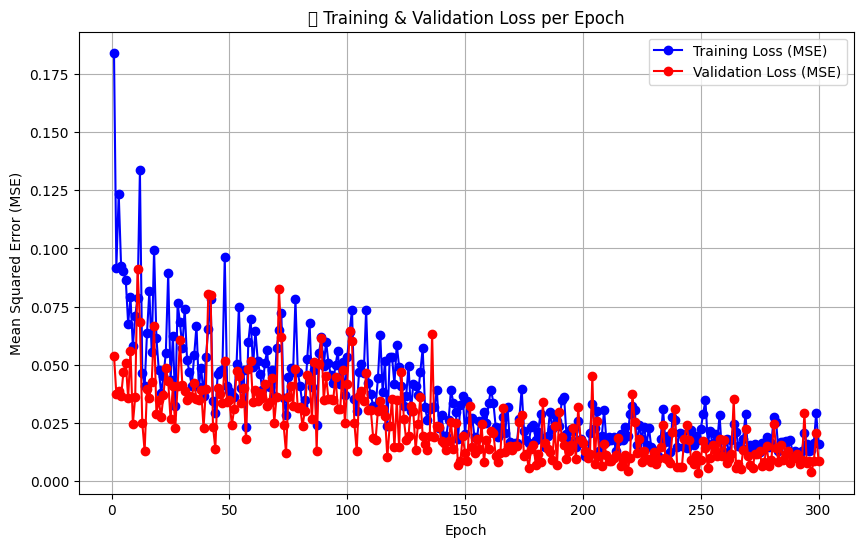

✅ Training completed!
✅ [RUN 1] MTL Average MAE: 0.1016

🔄 Training Single-Task Learning (STL without sharing) models per site...
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-1: MAE: 0.1553
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-2: MAE: 0.1588
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-3: MAE: 0.1565
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-4: MAE: 0.1867
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-5: MAE: 0.1790
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-6: MAE: 0.1853
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-7: MAE: 0.1483
Train size: 476 | Validation size: 118 | Test size: 149
✅ [RUN 1] STL without sharing Site-8: MAE: 0.1439
Train size: 593 | Vali

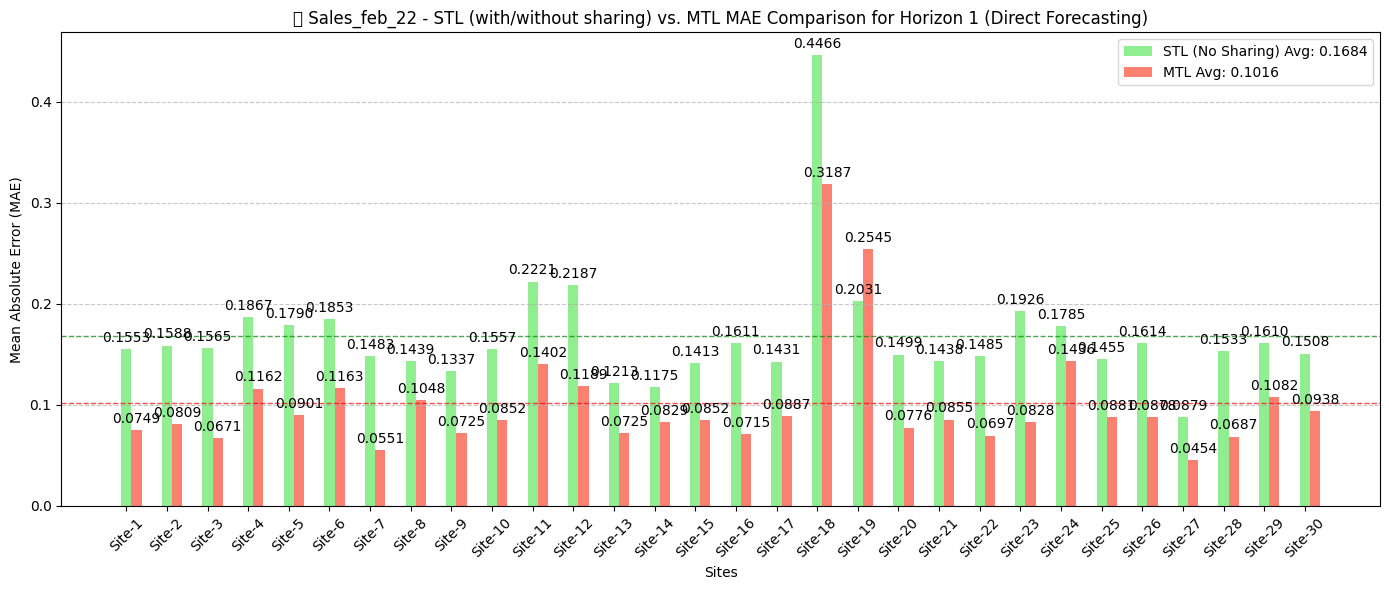

✅ Completed: Sales_feb_22 | Horizon: 1

==================== ⏳ HORIZON: 2 ====================
✅ Found sites: ['../processed_ds/stores_data/store-631/store-631.csv', '../processed_ds/stores_data/store-602/store-602.csv', '../processed_ds/stores_data/store-873/store-873.csv', '../processed_ds/stores_data/store-734/store-734.csv', '../processed_ds/stores_data/store-844/store-844.csv', '../processed_ds/stores_data/store-560/store-560.csv', '../processed_ds/stores_data/store-1017/store-1017.csv', '../processed_ds/stores_data/store-1067/store-1067.csv', '../processed_ds/stores_data/store-661/store-661.csv', '../processed_ds/stores_data/store-188/store-188.csv', '../processed_ds/stores_data/store-815/store-815.csv', '../processed_ds/stores_data/store-539/store-539.csv', '../processed_ds/stores_data/store-971/store-971.csv', '../processed_ds/stores_data/store-299/store-299.csv', '../processed_ds/stores_data/store-451/store-451.csv', '../processed_ds/stores_data/store-722/store-722.csv', '../p

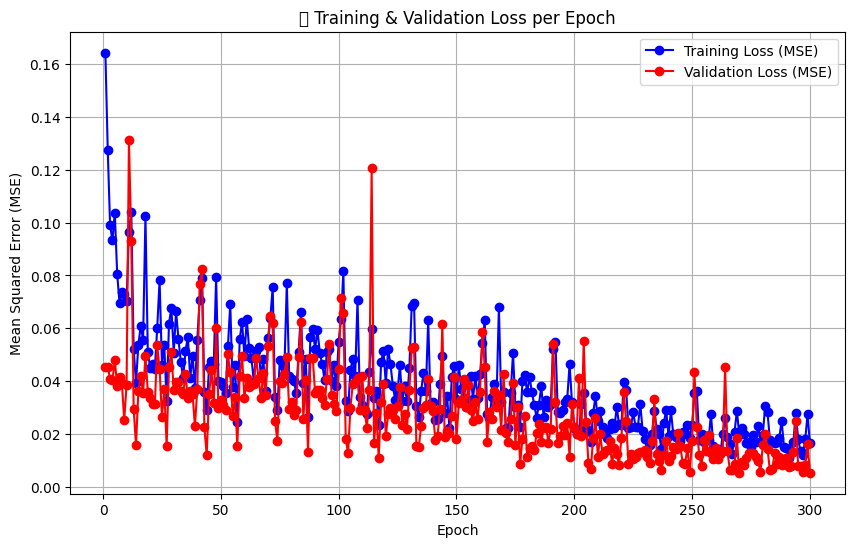

✅ Training completed!
✅ [RUN 1] MTL Average MAE: 0.1034

🔄 Training Single-Task Learning (STL without sharing) models per site...
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-1: MAE: 0.1831
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-2: MAE: 0.1602
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-3: MAE: 0.1641
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-4: MAE: 0.1897
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-5: MAE: 0.1699
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-6: MAE: 0.1842
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-7: MAE: 0.1543
Train size: 476 | Validation size: 118 | Test size: 149
✅ [RUN 1] STL without sharing Site-8: MAE: 0.1442
Train size: 593 | Vali

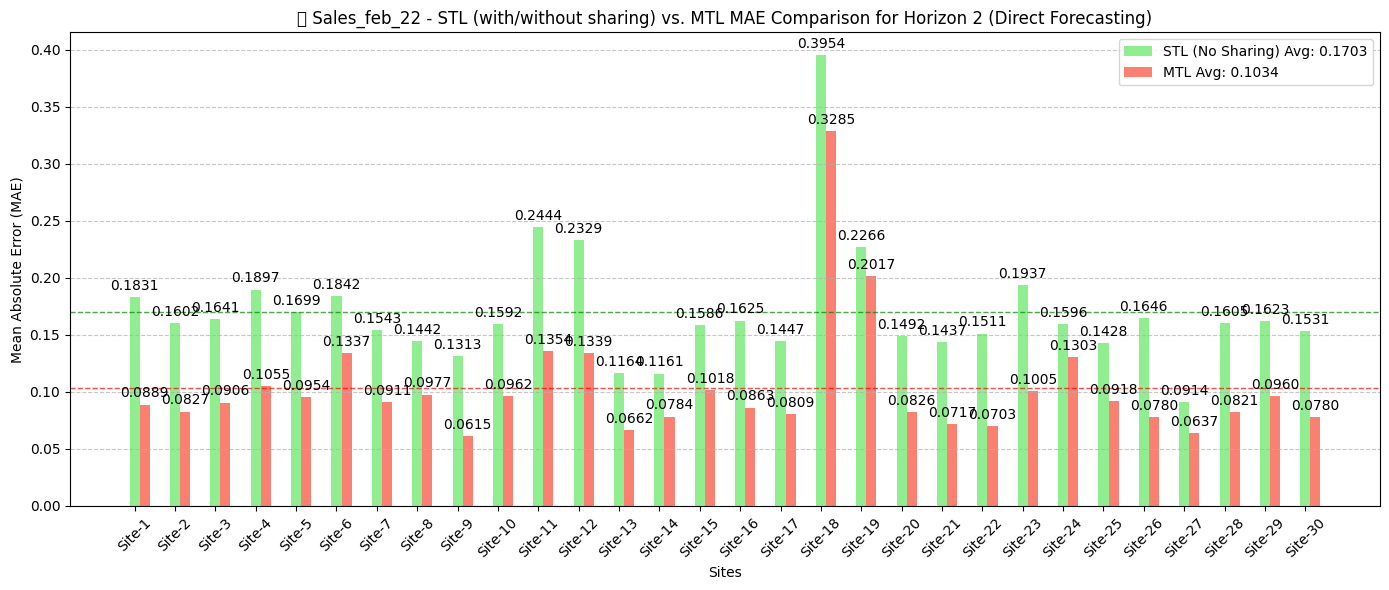

✅ Completed: Sales_feb_22 | Horizon: 2

==================== ⏳ HORIZON: 4 ====================
✅ Found sites: ['../processed_ds/stores_data/store-631/store-631.csv', '../processed_ds/stores_data/store-602/store-602.csv', '../processed_ds/stores_data/store-873/store-873.csv', '../processed_ds/stores_data/store-734/store-734.csv', '../processed_ds/stores_data/store-844/store-844.csv', '../processed_ds/stores_data/store-560/store-560.csv', '../processed_ds/stores_data/store-1017/store-1017.csv', '../processed_ds/stores_data/store-1067/store-1067.csv', '../processed_ds/stores_data/store-661/store-661.csv', '../processed_ds/stores_data/store-188/store-188.csv', '../processed_ds/stores_data/store-815/store-815.csv', '../processed_ds/stores_data/store-539/store-539.csv', '../processed_ds/stores_data/store-971/store-971.csv', '../processed_ds/stores_data/store-299/store-299.csv', '../processed_ds/stores_data/store-451/store-451.csv', '../processed_ds/stores_data/store-722/store-722.csv', '../p

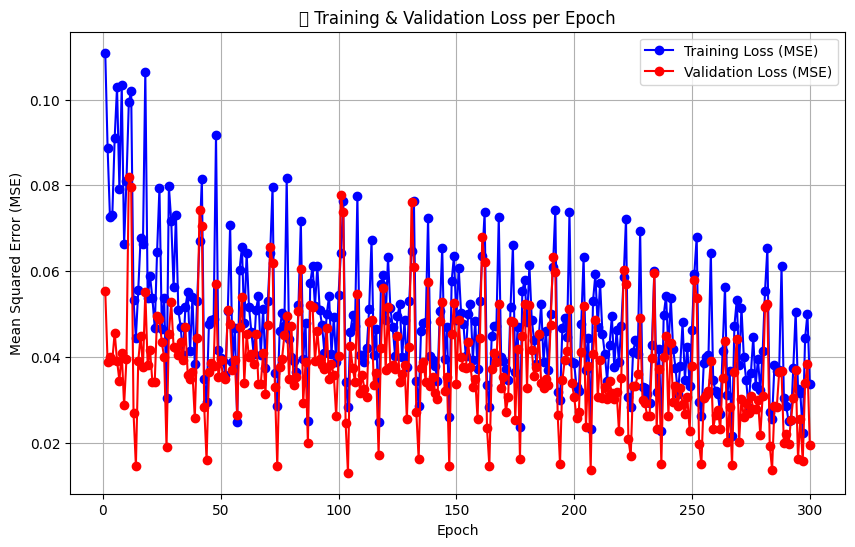

✅ Training completed!
✅ [RUN 1] MTL Average MAE: 0.1526

🔄 Training Single-Task Learning (STL without sharing) models per site...
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-1: MAE: 0.1541
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-2: MAE: 0.1598
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-3: MAE: 0.1622
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-4: MAE: 0.1902
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-5: MAE: 0.1860
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-6: MAE: 0.1896
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-7: MAE: 0.1476
Train size: 476 | Validation size: 118 | Test size: 149
✅ [RUN 1] STL without sharing Site-8: MAE: 0.1413
Train size: 593 | Vali

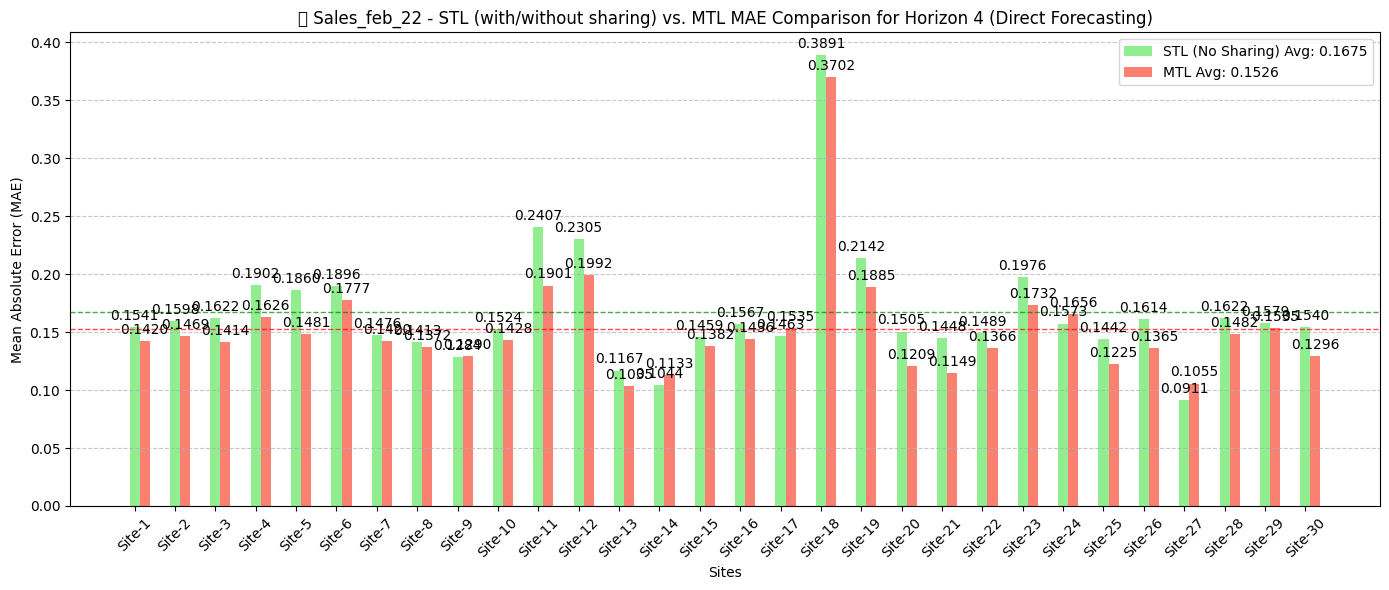

✅ Completed: Sales_feb_22 | Horizon: 4

==================== ⏳ HORIZON: 8 ====================
✅ Found sites: ['../processed_ds/stores_data/store-631/store-631.csv', '../processed_ds/stores_data/store-602/store-602.csv', '../processed_ds/stores_data/store-873/store-873.csv', '../processed_ds/stores_data/store-734/store-734.csv', '../processed_ds/stores_data/store-844/store-844.csv', '../processed_ds/stores_data/store-560/store-560.csv', '../processed_ds/stores_data/store-1017/store-1017.csv', '../processed_ds/stores_data/store-1067/store-1067.csv', '../processed_ds/stores_data/store-661/store-661.csv', '../processed_ds/stores_data/store-188/store-188.csv', '../processed_ds/stores_data/store-815/store-815.csv', '../processed_ds/stores_data/store-539/store-539.csv', '../processed_ds/stores_data/store-971/store-971.csv', '../processed_ds/stores_data/store-299/store-299.csv', '../processed_ds/stores_data/store-451/store-451.csv', '../processed_ds/stores_data/store-722/store-722.csv', '../p

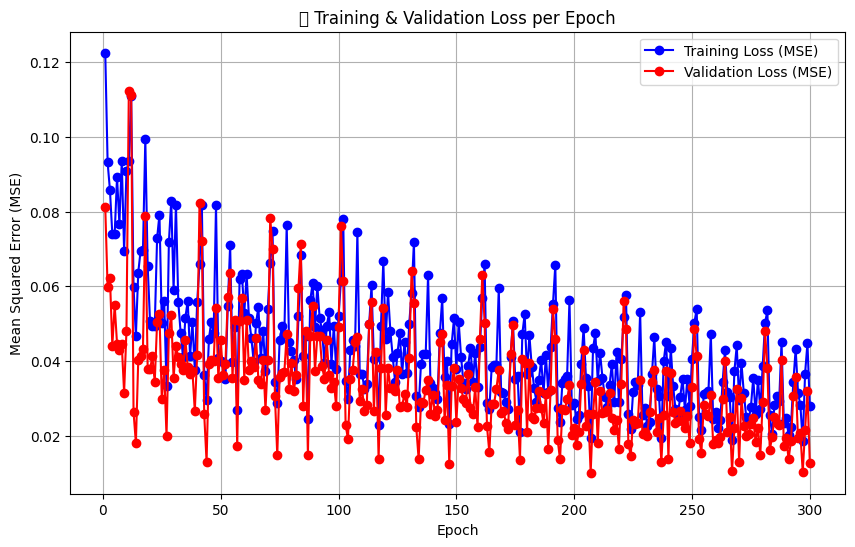

✅ Training completed!
✅ [RUN 1] MTL Average MAE: 0.1418

🔄 Training Single-Task Learning (STL without sharing) models per site...
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-1: MAE: 0.1505
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-2: MAE: 0.1592
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-3: MAE: 0.1615
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-4: MAE: 0.1551
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-5: MAE: 0.1695
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-6: MAE: 0.1920
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-7: MAE: 0.1348
Train size: 476 | Validation size: 118 | Test size: 149
✅ [RUN 1] STL without sharing Site-8: MAE: 0.1355
Train size: 593 | Vali

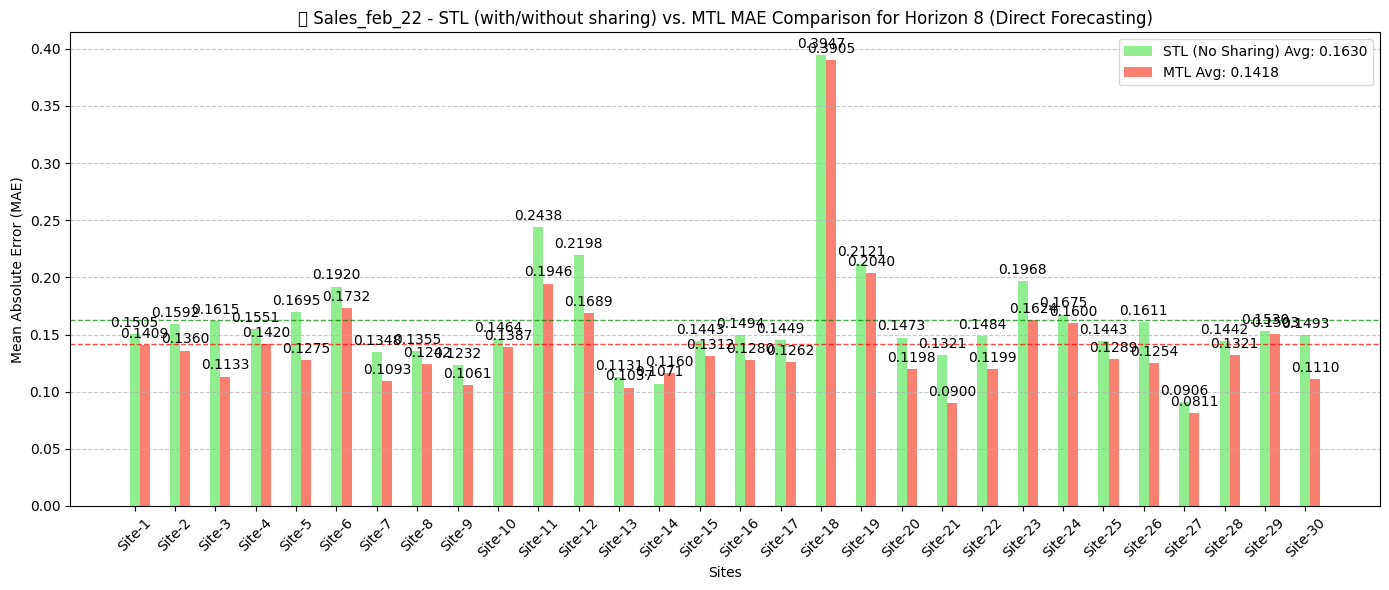

✅ Completed: Sales_feb_22 | Horizon: 8

==================== ⏳ HORIZON: 16 ====================
✅ Found sites: ['../processed_ds/stores_data/store-631/store-631.csv', '../processed_ds/stores_data/store-602/store-602.csv', '../processed_ds/stores_data/store-873/store-873.csv', '../processed_ds/stores_data/store-734/store-734.csv', '../processed_ds/stores_data/store-844/store-844.csv', '../processed_ds/stores_data/store-560/store-560.csv', '../processed_ds/stores_data/store-1017/store-1017.csv', '../processed_ds/stores_data/store-1067/store-1067.csv', '../processed_ds/stores_data/store-661/store-661.csv', '../processed_ds/stores_data/store-188/store-188.csv', '../processed_ds/stores_data/store-815/store-815.csv', '../processed_ds/stores_data/store-539/store-539.csv', '../processed_ds/stores_data/store-971/store-971.csv', '../processed_ds/stores_data/store-299/store-299.csv', '../processed_ds/stores_data/store-451/store-451.csv', '../processed_ds/stores_data/store-722/store-722.csv', '../

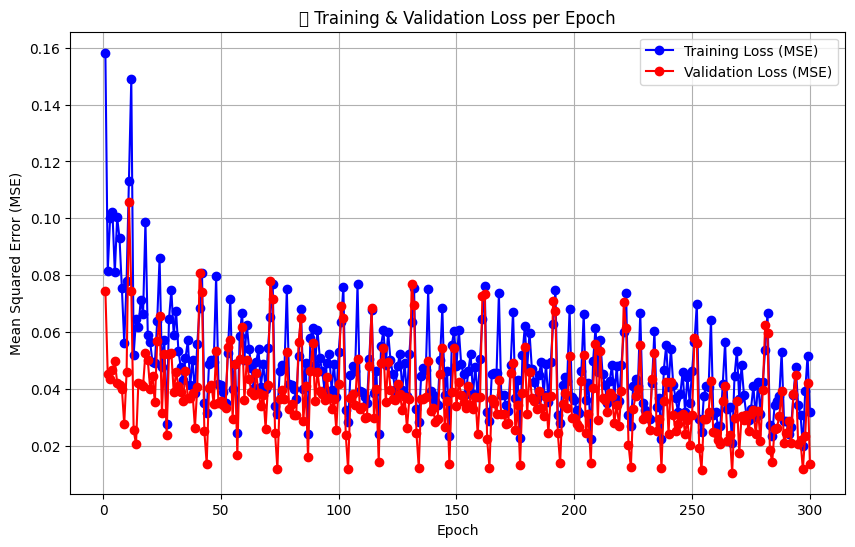

✅ Training completed!
✅ [RUN 1] MTL Average MAE: 0.1585

🔄 Training Single-Task Learning (STL without sharing) models per site...
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-1: MAE: 0.1558
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-2: MAE: 0.1579
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-3: MAE: 0.1619
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-4: MAE: 0.1935
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-5: MAE: 0.1753
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-6: MAE: 0.2014
Train size: 593 | Validation size: 148 | Test size: 186
✅ [RUN 1] STL without sharing Site-7: MAE: 0.1546
Train size: 476 | Validation size: 118 | Test size: 149
✅ [RUN 1] STL without sharing Site-8: MAE: 0.1322
Train size: 593 | Vali

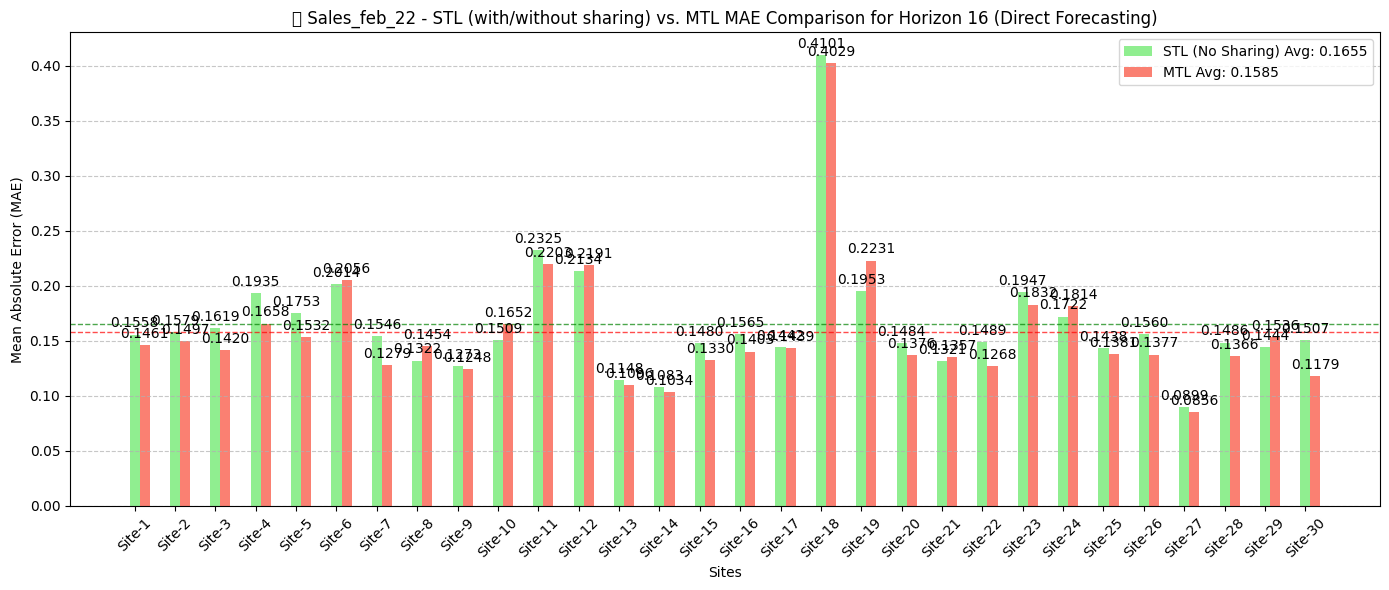

✅ Completed: Sales_feb_22 | Horizon: 16

🏆 All experiments completed successfully!


In [85]:
# 🔧 Training Configuration
device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'
lr = 5e-3 #0.0003 AQ Solar, Crypto
max_grad_norm = 0.5 #0.7 AQ Solar, Crypto
decay_rate = 0.95
decay_step_size = 1
dropout=0.3 #0.1 AQ Solar, Crypto
num_private_layers=  2 # AQ and SOLAR .],4: crypto
window_size = 32
method = "Direct Forecasting"
horizons = [1, 2, 4, 8, 16]

# 🌐 Dataset Configurations
datasets = [
    # {
    #     'ds': 'Solar_feb_22',
    #     'features': ['loc-1', 'loc-2', 'loc-3', 'loc-4'],
    #     'target': 'loc-1',
    #     'base_path': "../processed_ds/solar/",
    #     'min_date': "2006-09-01",
    #     'max_date': "2006-09-08 4:50"
    # },
    # {
    #     'ds': 'Air Quality_feb_22',
    #     'features': ['PM2.5', 'OT', 'PM10', 'NO2'],
    #     'target': 'PM2.5',
    #     'base_path': '../processed_ds/air_quality_cluster',
    #     'min_date': "2014-09-01",
    #     'max_date': "2014-11-12 19:00"
    # },
    # {
    #     'ds': 'Crypto_feb_22',
    #     'features': ['Open', 'High', 'Low', 'OT', 'Volume'],
    #     'target': 'OT',
    #     'base_path': "../processed_ds/crypto-data/",
    #     'min_date': "2018-04-01",
    #     'max_date': "2018-06-15"
    # },
    {
        'ds': 'Sales_feb_22',
        'features': ['OT', 'customers', 'open', 'promo', 'holiday'],
        'target': 'OT',
        'base_path': "../processed_ds/stores_data/",
        'min_date': "2013-01-16",
        'max_date': "2015-07-31"
    }
]

# 🚀 **Run All Datasets with All Horizons**
for dataset in datasets:
    print(f"\n==================== 🌟 DATASET: {dataset['ds']} ====================")
    for horizon in horizons:
        print(f"\n==================== ⏳ HORIZON: {horizon} ====================")
        run_experiments_stl_added(
            base_path=dataset['base_path'],
            num_runs=1,
            num_epochs=10,
            horizon=horizon,
            batch_size=64,
            d_model=32,
            lr=lr,
            max_grad_norm=max_grad_norm,
            decay_rate=decay_rate,
            decay_step_size=decay_step_size,
            dropout=dropout,
            num_private_layers=num_private_layers,
            device=device,
            features=dataset['features'],
            target=dataset['target'],
            method=method,
            min_date=dataset['min_date'],
            max_date=dataset['max_date'],
            ds=dataset['ds'],
        )
        print(f"✅ Completed: {dataset['ds']} | Horizon: {horizon}")

print("\n🏆 All experiments completed successfully!")


In [27]:
torch.cuda.empty_cache


<function torch.cuda.memory.empty_cache() -> None>